Título do Trabalho:Análise de Imagens Citológicas com SVM e Transfer Learning

Descrição: Neste trabalho será desenvolvido um sistema de apoio ao diagnóstico para detetar metástases em gânglios linfáticos de pacientes com cancro da mama, com recurso a imagens citológicas e dados suplementares do dataset SLN-Breast.

Serão aplicados métodos de Machine Learning (ML), nomeadamente:

Support Vector Machine (SVM)
Redes Neuronais clássicas (NN)
Adicionalmente, será explorado um método de Deep learning(DL) com recurso a Transfer Learning (TL), recorrendo a modelos pré-treinados para extrair características das imagens de patologia.

Os modelos serão avaliados com métricas como exatidão, precisão, sensibilidade e matriz de confusão, comparando o desempenho entre abordagens clássicas e baseadas em deep learning.

In [1]:
#Importação de bibliotecas
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openslide #para carregar os ficheiros .svs
import random
import os
from PIL import Image
from tqdm import tqdm  # barra de progresso
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc as calc_auc, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from skimage.transform import resize
from tensorflow.keras.applications import ResNet50, resnet50, EfficientNetB0
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,  GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau)



Carregamento e visualização do DataSet

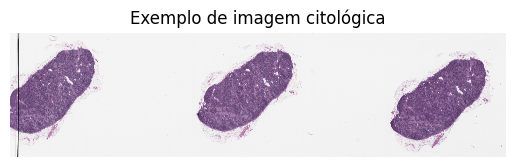

In [2]:
#carregar e visualizar as imagens 

# Caminho para a pasta onde estão os ficheiros .svs
image_folder = "/Volumes/TOSHIBA EXT/Trabalho final/SLN-Breast"
image_files = os.listdir(image_folder)

# Aumentar o limite de pixels para evitar o erro DecompressionBombError
Image.MAX_IMAGE_PIXELS = None

#Carregar e mostrar uma imagem de exemplo
img_path = os.path.join(image_folder, image_files[0])
img = Image.open(img_path)

plt.imshow(img)
plt.title("Exemplo de imagem citológica")
plt.axis('off')
plt.show()

In [3]:
# Carregar dados suplementares
df = pd.read_csv("/Volumes/TOSHIBA EXT/Trabalho final/SLN-Breast/target.csv")

# Visualizar as primeiras linhas
print(df.head())

# Verificar distribuição das classes
print(df['target'].value_counts())

                     slide  target
0  HobI16-053768896760.svs       1
1  HobI16-072823783181.svs       1
2  HobI16-105105202254.svs       0
3  HobI16-303757967057.svs       0
4  HobI16-334188031493.svs       0
target
0    94
1    36
Name: count, dtype: int64


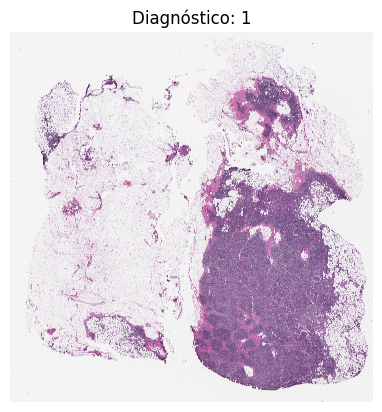

In [4]:
#Combinar as imagens com os dados do CSV
# Exemplo: carregar uma imagem com base no nome no CSV
sample = df.iloc[0]
img_path = os.path.join(image_folder, sample['slide'])
img = Image.open(img_path)

plt.imshow(img)
plt.title(f"Diagnóstico: {sample['target']}")
plt.axis('off')
plt.show()


Pré-processamento

O que é que está ser feito e porquê?  Extraímos uma parte da imagem com área de 1000x1000 em vez da imagem completa com zoom 0 (maior resolução) e depois é redimensionado para 224x224 pois é a dimensão que alguns modelos de deep learning esperam. Assim o redimensionamento garente compatibilidade com os modelos. Apesar de poder haver perda de detalhe, permite treinar os modelos de forma mais rápida exigindo menos poder de computação. Existe um compromisso entre a capacidade de computação e preservação da informação. Caso o modelo não tenha uma boa performance ajustamos este redimensionamento. A normalização serve para colocar os valores dos píxeis entre 0.0 e 1.0 para melhorar a eficiência do treino e estabilidade numérica do modelo.

In [5]:
# ---  Pré-processar cada imagem ---

patch_size = 224
n_patches_por_classe = 500 # número de patches por classe para ajudar a equilibrar o dataset
min_tissue_ratio = 0.6  # número de patches por imagem
data = []
counts_per_class = defaultdict(int)

# Agrupar imagens por classe para facilitar a extração balanceada
df_grouped = df.groupby('target')


# Vai tentar extrair patches para cada classe até atingir n_patches_por_classe
for classe, grupo in df_grouped:
    print(f"[INFO] A extrair patches da classe {classe}...")
    imagens_classe = grupo['slide'].tolist()
    random.shuffle(imagens_classe)  # embaralha a ordem das imagens
    
    idx_imagem = 0
    while counts_per_class[classe] < n_patches_por_classe:
        if idx_imagem >= len(imagens_classe):
            print(f"[AVISO] Imagens acabaram antes de atingir {n_patches_por_classe} patches para a classe {classe}")
            break
        
        file_path = os.path.join(image_folder, imagens_classe[idx_imagem])
        idx_imagem += 1
        
        try:
            slide = openslide.OpenSlide(file_path)
            slide_w, slide_h = slide.dimensions
            
            patches_collected = 0
            max_attempts = 100  # limite para evitar loops infinitos em imagens sem patches válidos
            attempts = 0
            
            while patches_collected < n_patches_por_classe // len(imagens_classe) and attempts < max_attempts:
                x = random.randint(0, slide_w - patch_size)
                y = random.randint(0, slide_h - patch_size)
                
                patch = slide.read_region((x, y), 0, (patch_size, patch_size)).convert("RGB")
                patch_array = np.array(patch) / 255.0
                
                tissue_ratio = (patch_array.mean(axis=2) < 0.9).mean()
                if tissue_ratio >= min_tissue_ratio:
                    data.append((patch_array, classe))
                    counts_per_class[classe] += 1
                    patches_collected += 1
                attempts += 1
                
        except Exception as e:
            print(f"[ERRO] {file_path}: {e}")

print("[INFO] Distribuição final de patches por classe:")
for classe, count in counts_per_class.items():
    print(f"Classe {classe}: {count} patches")

# Converter para arrays numpy
X = np.array([img for img, _ in data])
y = np.array([label for _, label in data])
print(f"Total patches: {len(X)} | Shape: {X.shape} | Class distribution: {np.bincount(y)}")




[INFO] A extrair patches da classe 0...
[AVISO] Imagens acabaram antes de atingir 500 patches para a classe 0
[INFO] A extrair patches da classe 1...
[AVISO] Imagens acabaram antes de atingir 500 patches para a classe 1
[INFO] Distribuição final de patches por classe:
Classe 0: 462 patches
Classe 1: 381 patches
Total patches: 843 | Shape: (843, 224, 224, 3) | Class distribution: [462 381]


Modelos de ML (Machine Learning)

1) SVM

[INFO] A redimensionar patches para 64x64...
[INFO] A aplicar PCA para manter 95% da variância...
[INFO] Número de componentes selecionados: 449


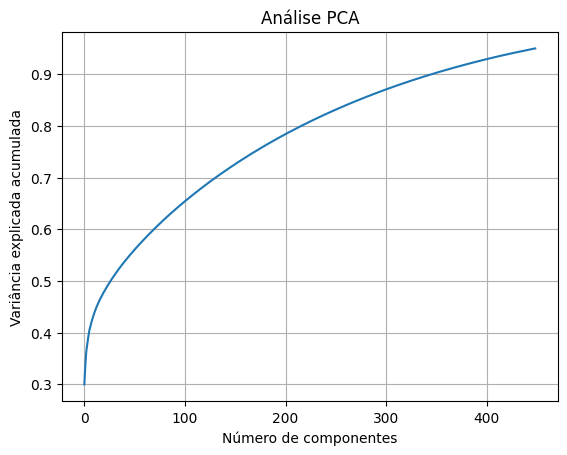

[INFO] A iniciar GridSearchCV para SVM...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END .................................C=0.01, gamma=0.01; total time=   0.2s
[CV] END ................................C=0.01, gamma=scale; total time=   0.2s
[CV] END .................................C=0.01, gamma=auto; total time=   0.2s
[CV] END ................................C=0.01, gamma=scale; total time=   0.2s
[CV] END .................................C=0.01, gamma=auto; total time=   0.2s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.3s
[CV] END ................................C=0.01, gamma=scale; total time=   0.3s
[CV] END .................................C=0.01, gamma=auto; total time=   0.3s
[CV] END ..................................C=0.01, gamma=0.1; total time=   0.2s
[CV] END ..................................C=0.01, gamma=0.1; total time=   0.2s
[CV] END ..................................C=0.01, gamma=0.1; total time=   0.2s
[CV] E

In [6]:
# Redimensionar para 64x64
print("[INFO] A redimensionar patches para 64x64...")
X_resized = np.array([resize(img, (64, 64), anti_aliasing=True) for img in X])

# Flatten das imagens
X_flat = X_resized.reshape(X_resized.shape[0], -1)

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.2, random_state=42, stratify=y
)

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA para reduzir dimensão
print("[INFO] A aplicar PCA para manter 95% da variância...")
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"[INFO] Número de componentes selecionados: {pca.n_components_}")

# Visualizar variância explicada acumulada
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Variância explicada acumulada')
plt.title('Análise PCA')
plt.grid(True)
plt.show()

# Definir e ajustar SVM com calibragem e GridSearchCV
print("[INFO] A iniciar GridSearchCV para SVM...")
svm = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10]
}

grid = GridSearchCV(svm, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=2)
grid.fit(X_train_pca, y_train)
print(f"[INFO] Melhores parâmetros encontrados: {grid.best_params_}")

# Calibrar o melhor modelo encontrado
best_svm = grid.best_estimator_
calibrated_svm = CalibratedClassifierCV(best_svm, cv=5)
calibrated_svm.fit(X_train_pca, y_train)

# Prever probabilidades com modelo calibrado
y_scores = calibrated_svm.predict_proba(X_test_pca)[:, 1]
y_pred = calibrated_svm.predict(X_test_pca)

# Avaliar o modelo
print("[INFO] Métricas de avaliação:")
print(classification_report(y_test, y_pred))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))


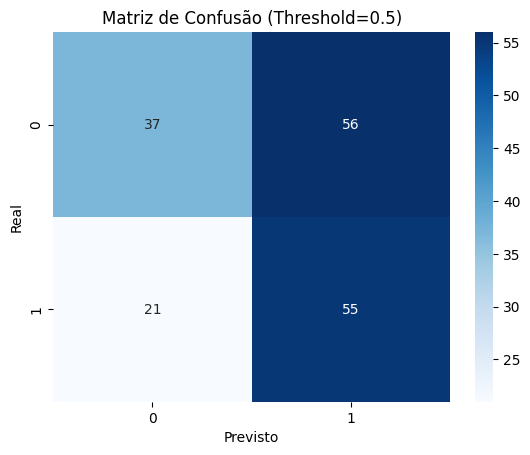

              precision    recall  f1-score   support

           0       0.64      0.40      0.49        93
           1       0.50      0.72      0.59        76

    accuracy                           0.54       169
   macro avg       0.57      0.56      0.54       169
weighted avg       0.57      0.54      0.53       169

AUC: 0.561


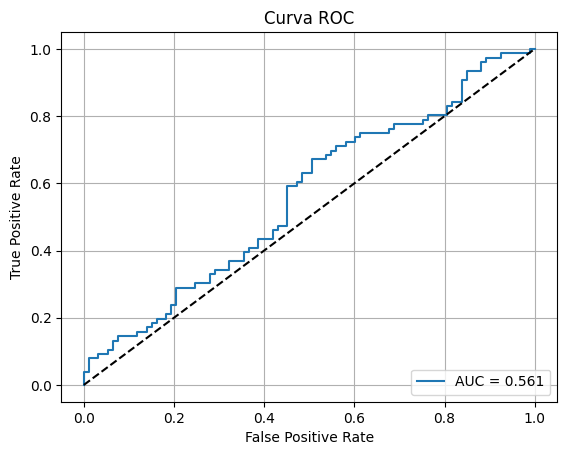

In [9]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão (Threshold=0.5)")
plt.show()

# Relatório de classificação e AUC
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_scores)
print(f"AUC: {auc:.3f}")

# Plot da Curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')  # linha diagonal base
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



In [10]:
# Sem PCA e sem SMOTE
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(X_flat, y, test_size=0.2, random_state=42)

lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train_simple, y_train_simple)

y_scores_lr = lr.predict_proba(X_test_simple)[:,1]
y_pred_lr = lr.predict(X_test_simple)

from sklearn.metrics import confusion_matrix, roc_auc_score
print("Matriz de Confusão:\n", confusion_matrix(y_test_simple, y_pred_lr))
print("AUC:", roc_auc_score(y_test_simple, y_scores_lr))

Matriz de Confusão:
 [[46 46]
 [32 45]]
AUC: 0.5405138339920948


[INFO] A redimensionar patches para 64x64...
[INFO] A aplicar PCA para manter 95% da variância...
[INFO] Número de componentes após PCA: 449
[INFO] A aplicar SelectKBest para escolher as melhores features...
[INFO] Features após SelectKBest: 100
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .................................C=0.1, gamma=scale; total time=   0.1s
[CV] END .................................C=0.1, gamma=scale; total time=   0.1s
[CV] END .................................C=0.1, gamma=scale; total time=   0.1s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.1s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.1s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.1s
[CV] END ...................................C=

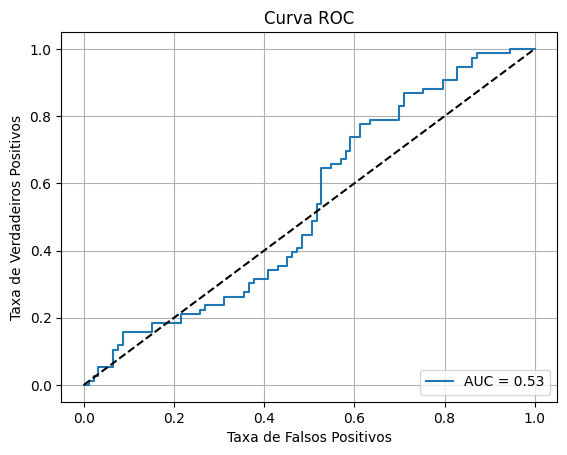

In [16]:
# Redimensionar para 64x64
print("[INFO] A redimensionar patches para 64x64...")
X_resized = np.array([resize(img, (64, 64), anti_aliasing=True) for img in X])

# Flatten das imagens
X_flat = X_resized.reshape(X_resized.shape[0], -1)

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.2, random_state=42, stratify=y
)

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA para manter 95% da variância
print("[INFO] A aplicar PCA para manter 95% da variância...")
pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"[INFO] Número de componentes após PCA: {X_train_pca.shape[1]}")

# Feature selection com SelectKBest
print("[INFO] A aplicar SelectKBest para escolher as melhores features...")
k = min(100, X_train_pca.shape[1])  # usar 100 ou o máximo possível
selector = SelectKBest(score_func=f_classif, k=k)
X_train_sel = selector.fit_transform(X_train_pca, y_train)
X_test_sel = selector.transform(X_test_pca)
print(f"[INFO] Features após SelectKBest: {X_train_sel.shape[1]}")

# Treinar SVM com GridSearch
svm = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1]
}
grid = GridSearchCV(svm, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=2)
grid.fit(X_train_sel, y_train)
print(f"[INFO] Melhores parâmetros encontrados: {grid.best_params_}")

# Calibração
best_svm = grid.best_estimator_
calibrated_svm = CalibratedClassifierCV(best_svm, cv=5)
calibrated_svm.fit(X_train_sel, y_train)

# Previsões
y_scores = calibrated_svm.predict_proba(X_test_sel)[:, 1]
y_pred = calibrated_svm.predict(X_test_sel)


# Avaliação
print("[INFO] Resultados:")
print(classification_report(y_test, y_pred, zero_division=0))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = calc_auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

2) Neural Network

In [17]:
# Normalizar os dados antes do PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar PCA (ex: 50 componentes)
pca = PCA(n_components=70)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [18]:
# Etapa 1: Criar o classificador MLP
mlp = MLPClassifier(max_iter=500, random_state=42)

# Etapa 2: Definir o grid de hiperparâmetros
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (10, 10)],
    'activation': ['logistic', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant']
}



# Etapa 3: Pesquisa em grelha com validação cruzada (5-fold)
grid_search = GridSearchCV(mlp, param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)


/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multi

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=500, random_state=42),
             param_grid={'activation': ['logistic', 'relu'],
                         'hidden_layer_sizes': [(50,), (100,), (10, 10)],
                         'learning_rate': ['constant'],
                         'solver': ['sgd', 'adam']})

In [19]:
# Etapa 4: Resultados
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

# Etapa 5: Previsões no teste
y_pred = best_model.predict(X_test_pca)
y_prob = best_model.predict_proba(X_test_pca)[:, 1]

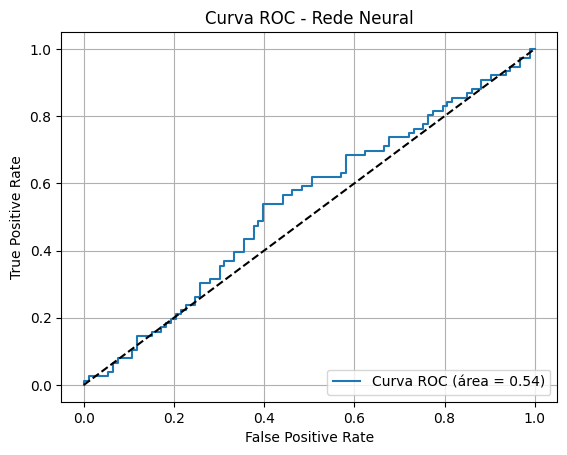

In [22]:

# Etapa 6: Relatório e matriz

report = classification_report(y_test, y_pred, target_names=["Sem Metástase", "Com Metástase"])
matrix = confusion_matrix(y_test, y_pred)

# Etapa 7: Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = calc_auc(fpr, tpr)

# Probabilidades da classe positiva (metástase)
y_prob = best_model.predict_proba(X_test_pca)[:, 1]

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # linha diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Rede Neural')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



               precision    recall  f1-score   support

Sem Metástase       0.61      0.54      0.57        93
Com Metástase       0.51      0.58      0.54        76

     accuracy                           0.56       169
    macro avg       0.56      0.56      0.56       169
 weighted avg       0.56      0.56      0.56       169



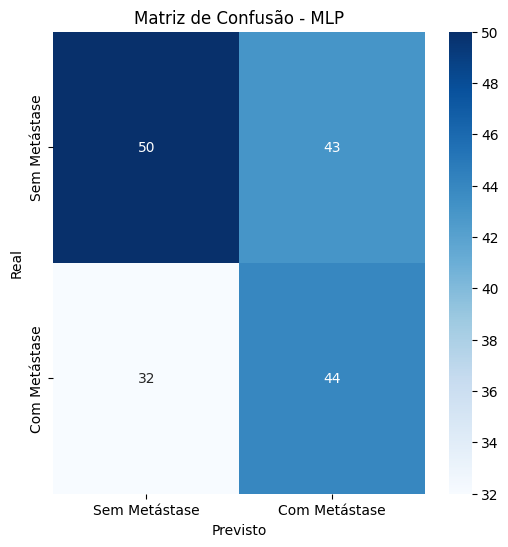

In [23]:
# Fazer previsões com o modelo MLP
y_pred = best_model.predict(X_test_pca)

# Gerar matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Imprimir relatório de classificação
print(classification_report(y_test, y_pred, target_names=["Sem Metástase", "Com Metástase"]))

# Plotar a matriz de confusão
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Sem Metástase", "Com Metástase"],
            yticklabels=["Sem Metástase", "Com Metástase"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - MLP")
plt.show()

Deep Learning

Agora vamos treinar um modelo de deep learning para classificar as imagens como com metástase (target=1) ou sem metástase (target=0), utilizando transfer learning com um modelo pré-treinado

In [ ]:
# --- Dividir e guardar patches em diretórios ---
base_dir = "/Volumes/TOSHIBA EXT/Trabalho final/PKG - SLN-Breast"
train_dir, test_dir = os.path.join(base_dir, "train"), os.path.join(base_dir, "test")
for d in [train_dir, test_dir]:
    for c in ["0", "1"]:
        os.makedirs(os.path.join(d, c), exist_ok=True)

X_train_DL, X_test_DL, y_train_DL, y_test_DL = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

def save_images(X, y, path_prefix):
    for i, (img_array, label) in enumerate(zip(X, y)):
        img = Image.fromarray((img_array * 255).astype(np.uint8))
        img.save(os.path.join(path_prefix, str(label), f"{path_prefix.split('/')[-1]}_{i}.png"))

save_images(X_train_DL, y_train_DL, train_dir)
save_images(X_test_DL, y_test_DL, test_dir)

# --- Geradores de dados ---
img_size = (224, 224)
batch_size = 16

datagen = ImageDataGenerator(rescale=1./255)  # Caso os dados tenham sido guardados sem normalizar

train_ds = datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='binary')
test_ds = datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='binary', shuffle=False)

# --- Modelagem com EfficientNetB0 ---
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=base_model.input, outputs=out)
model.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# --- Class weights ---
y_train_DL_labels = train_ds.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_DL_labels), y=y_train_DL_labels)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# --- Treinar modelo ---
cb = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(patience=3, factor=0.2),
    #callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
]

history = model.fit(train_ds, validation_data=test_ds, epochs=30, class_weight=class_weights, callbacks=cb)



Found 1689 images belonging to 2 classes.
Found 423 images belonging to 2 classes.
Class weights: {0: np.float64(0.9041755888650964), 1: np.float64(1.1185430463576158)}


/opt/homebrew/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 71s 632ms/step - accuracy: 0.4940 - loss: 0.7069 - val_accuracy: 0.4634 - val_loss: 0.7080 - learning_rate: 1.0000e-04
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.4941 - loss: 0.7017 - val_accuracy: 0.4634 - val_loss: 0.6973 - learning_rate: 1.0000e-04
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 388s 4s/step - accuracy: 0.4916 - loss: 0.6995 - val_accuracy: 0.4634 - val_loss: 0.6968 - learning_rate: 1.0000e-04
Epoch 4/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 785ms/step - accuracy: 0.5174 - loss: 0.6926 - val_accuracy: 0.4586 - val_loss: 0.6936 - learning_rate: 1.0000e-04
Epoch 5/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 67s 626ms/step - accuracy: 0.5145 - loss: 0.6950 - val_accuracy: 0.4634 - val_loss: 0.6945 - learning_rate: 1.0000e-04
Epoch 6/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 42s 398ms/step - accuracy: 0.4965 - loss: 0.6934 - val_accuracy: 0.4634 - val_loss: 0.6955 - learning_rate: 1.0000e-04
Epoch 7/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 42s 399ms/

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 386ms/step - accuracy: 0.8438 - loss: 0.6624
Accuracy: 0.537
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 416ms/step
AUC-ROC: 0.536
Threshold ótimo: 0.477


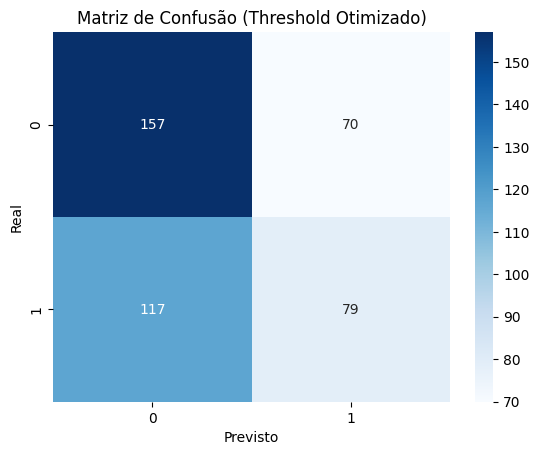

              precision    recall  f1-score   support

           0       0.57      0.69      0.63       227
           1       0.53      0.40      0.46       196

    accuracy                           0.56       423
   macro avg       0.55      0.55      0.54       423
weighted avg       0.55      0.56      0.55       423



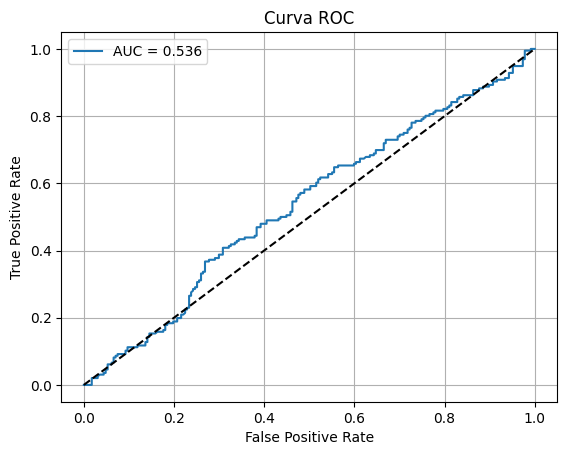

In [25]:
#Avaliação geral do modelo
loss, acc = model.evaluate(test_ds)
print(f"Accuracy: {acc:.3f}")

# Extrair rótulos reais e previsões
y_true = test_ds.labels
y_probs = model.predict(test_ds).ravel()


# AUC-ROC
auc_score = roc_auc_score(y_true, y_probs)
print(f"AUC-ROC: {auc_score:.3f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Threshold ótimo: {optimal_threshold:.3f}")

# Previsões com threshold otimizado
y_pred_opt = (y_probs > optimal_threshold).astype(int)

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred_opt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão (Threshold Otimizado)")
plt.show()

# Relatório de classificação
class_names = ['0', '1']
print(classification_report(y_true, y_pred_opt, target_names=class_names))

# Curva ROC
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid()
plt.show()

Extra ao trabalho: Carregar imagens com metástases e assinalar na imagem onde estas se encontram

In [ ]:
# Antes do flatten e scaling:
X_resized = np.array([resize(img, (224, 224), anti_aliasing=True) for img in X])

# Função para mostrar imagem com legenda de predição

def mostrar_imagem_assinada(imagem, probabilidade, limiar=0.5):
    """
    Mostra uma imagem com a assinatura da predição.
    """
    label = "Metástase" if probabilidade >= limiar else "Sem Metástase"
    cor = "red" if label == "Metástase" else "green"
    
    plt.imshow(imagem)
    plt.title(f"{label} ({probabilidade:.2f})", color=cor, fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Função para mostrar até n imagens com metástase prevista

def mostrar_predicoes_metastase(X_test_scaled, y_scores, n=5, limiar=0.5):
    """
    Mostra até n imagens do conjunto de teste com metástase prevista
    com base na probabilidade do classificador.
    """
    # Reconstruir imagens a partir dos vetores flatten
    X_test_imgs = X_test_scaled.reshape(-1, 224, 224, 3)

    # Índices das imagens com predição de metástase acima do limiar
    indices_metastase_predita = np.where(y_scores >= limiar)[0]

    print(f"[INFO] Total de imagens com metástase prevista (prob >= {limiar}): {len(indices_metastase_predita)}")

    # Mostrar até n imagens
    for i in indices_metastase_predita[:n]:
        mostrar_imagem_assinada(X_test_imgs[i], y_scores[i], limiar=limiar)


# Exemplo de utilização após prever com o modelo calibrado

# y_scores = calibrated_svm.predict_proba(X_test_scaled)[:, 1]

# Mostrar 5 imagens com maior probabilidade de metástase
mostrar_predicoes_metastase(X_test_scaled, y_scores, n=5, limiar=0.5)
